In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

# Reading, cleaning and splitting datasets

In [4]:
# reading csv files and creating dataframes
df_evandro = pd.read_csv('Evandro.csv', sep=';', encoding='latin-1')
df_celso = pd.read_csv('Celso.csv', sep=';', encoding='latin-1')
df_eliezer = pd.read_csv('Eliezer.csv', sep=';', encoding='latin-1')

# drop NaN values (if any)
df_evandro.dropna(inplace=True)
df_celso.dropna(inplace=True)
df_eliezer.dropna(inplace=True)

# check maximum row numbers
maxRows = [df_evandro.shape[0], df_eliezer.shape[0], df_celso.shape[0]]
#maxRows.sort()
maxRows[0] = 10287

# slice dataframes in order to equalize the length
df_evandro = df_evandro.loc[:maxRows[0]-1,:]
df_celso = df_celso.loc[:maxRows[0]-1,:]
df_eliezer = df_eliezer.loc[:maxRows[0]-1,:]

# converting Event Types into binary classification
#df_evandro['Event Type'] = df_evandro['Event Type'].apply(lambda s: 0 if s=='mouseMove' else 1)
#df_celso['Event Type'] = df_celso['Event Type'].apply(lambda s: 0 if s=='mouseMove' else 1)
#df_eliezer['Event Type'] = df_eliezer['Event Type'].apply(lambda s: 0 if s=='mouseMove' else 1)

# drop useless data
df_evandro.drop(['Date', 'Time', 'Event Type'], axis=1, inplace=True)
df_celso.drop(['Date', 'Time', 'Event Type'], axis=1, inplace=True)
df_eliezer.drop(['Date', 'Time', 'Event Type'], axis=1, inplace=True)

# splitting into training data
df_evandro_train = df_evandro.loc[:maxRows[0]*0.75,:]
df_celso_train = df_celso.loc[:maxRows[0]*0.75,:]
df_eliezer_train = df_eliezer.loc[:maxRows[0]*0.75,:]

# splitting into testing data
df_evandro_test = df_evandro.loc[maxRows[0]*0.75:,:].reset_index(drop=True)
df_celso_test = df_celso.loc[maxRows[0]*0.75:,:].reset_index(drop=True)
df_eliezer_test = df_eliezer.loc[maxRows[0]*0.75:,:].reset_index(drop=True)

df_evandro_train.head()

,EventId,Coordinate X,Coordinate Y
0,22210384,369,402
1,22210384,639,447
2,22210384,702,460
3,799803936,707,461
4,799803936,1056,432


# Adding new variables to the training dataset

In [5]:
def createFeatures(df):
    offset_list, xm_list, ym_list, xstd_list, ystd_list, distm_list, diststd_list, arct_list = ([] for i in range(8))

    # deleting rows with coordinate X being 0
    df = df[df['Coordinate X'] != 0]

    # filtering unique id == 1 
    ulist = df['EventId'].unique()
    for u in ulist:
        df_unique = df[df['EventId'] == u]
        if df_unique.shape[0] == 1: # original is "== 1"
            df = df[df['EventId'] != u]

    # list of unique id with occurrence > 1
    ulist = df['EventId'].unique()

    for u in ulist:
        df_unique = df[df['EventId'] == u]

        # adding mean
        x_mean = df_unique['Coordinate X'].mean()
        y_mean = df_unique['Coordinate Y'].mean()
        xm_list.append(x_mean)
        ym_list.append(y_mean)
        
        # adding std
        xstd_list.append(df_unique['Coordinate X'].std())
        ystd_list.append(df_unique['Coordinate Y'].std())

        # calculating euclidean distances
        arr = np.array([(x, y) for x, y in zip(df_unique['Coordinate X'], df_unique['Coordinate Y'])])
        dist = [np.linalg.norm(arr[i+1]-arr[i]) for i in range(arr.shape[0]-1)]
        ideal_dist = np.linalg.norm(arr[arr.shape[0]-1]-arr[0])

        # adding offset
        offset_list.append(sum(dist)-ideal_dist)

        # adding distance mean
        distm_list.append(np.asarray(dist).mean())

        # adding distance std deviation
        diststd_list.append(np.asarray(dist).std())

        # adding slope angle of the tangent (arctan(Ym/Xm))
        arct_list.append(np.arctan(y_mean/x_mean))

    # create df subset with the new features
    df_subset = pd.DataFrame(ulist, columns=['EventId'])

    #df_subset['X Mean'] = xm_list
    #df_subset['Y Mean'] = ym_list
    #df_subset['X Std Dev'] = xstd_list
    #df_subset['Y Std Dev'] = ystd_list
    df_subset['Dist Mean'] = distm_list
    df_subset['Dist Std Dev'] = diststd_list
    df_subset['Offset'] = offset_list
    df_subset['Slope Mean'] = arct_list

    # drop EventId
    df_subset.drop(['EventId'], axis=1, inplace=True)
    
    return df_subset

In [6]:
df_evandro_train = createFeatures(df_evandro_train)
df_celso_train = createFeatures(df_celso_train)
df_eliezer_train = createFeatures(df_eliezer_train)

# get the minimum number of rows
maxRows = [df_evandro_train.shape[0], df_celso_train.shape[0], df_eliezer_train.shape[0]]
maxRows.sort()

# slice dataframes in order to equalize the length
df_evandro_train = df_evandro_train.loc[:maxRows[0]-1,:]
df_celso_train = df_celso_train.loc[:maxRows[0]-1,:]
df_eliezer_train = df_eliezer_train.loc[:maxRows[0]-1,:]

df_evandro_train.head()

,Dist Mean,Dist Std Dev,Offset,Slope Mean
0,169.025801,104.698513,0.038289,0.653346
1,200.011237,150.191562,1.520277,0.435367
2,11.180340,0.000000,0.000000,0.492810
3,449.587589,0.000000,0.000000,0.814141
4,166.053799,15.784041,0.562729,1.088295


# Standardizing the data for training datasets

In [7]:
def standardize(df):
    # instanciate StandardScaler object
    scaler = StandardScaler()

    # compute the mean and std to be used for later scaling
    scaler.fit(df)

    # perform standardization by centering and scaling
    scaled_features = scaler.transform(df)

    return pd.DataFrame(scaled_features)

# standardizing training datasets
df_evandro_train = standardize(df_evandro_train)
df_celso_train = standardize(df_celso_train)
df_eliezer_train = standardize(df_eliezer_train)

df_evandro_train.head()

,0,1,2,3
0,0.924829,0.977374,-0.193300,0.343419
1,1.219602,1.708958,-0.157997,-0.279342
2,-0.576797,-0.706308,-0.194212,-0.115229
3,3.593888,-0.706308,-0.194212,0.802806
4,0.896556,-0.452481,-0.180807,1.586058


# Running PCA on training datasets

In [8]:
# applying PCA and concat on train datasets
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

principalComponents = pca.fit_transform(df_evandro_train)
df_evandro_train_pca = pd.DataFrame(data = principalComponents)

# labeling observations
df_evandro_train_pca['Label'] = [1 for s in range(df_evandro_train_pca.shape[0])]

principalComponents = pca.fit_transform(df_celso_train)
df_celso_train_pca = pd.DataFrame(data = principalComponents)

# labeling observations
df_celso_train_pca['Label'] = [0 for s in range(df_celso_train_pca.shape[0])]

principalComponents = pca.fit_transform(df_eliezer_train)
df_eliezer_train_pca = pd.DataFrame(data = principalComponents)

# labeling observations
df_eliezer_train_pca['Label'] = [0 for s in range(df_eliezer_train_pca.shape[0])]

df_shuffle_train = pd.concat([df_evandro_train_pca, df_celso_train_pca, df_eliezer_train_pca])
df_shuffle_train = df_shuffle_train.sample(frac=1).reset_index(drop=True)

df_shuffle_train.head()
df_evandro_train_pca.head()

,0,1,2,Label
0,1.270405,-0.591214,0.038615,1
1,2.050723,-0.217958,-0.333509,1
2,-0.910007,0.101481,-0.199084,1
3,1.908704,-1.041957,-0.040875,1
4,0.135068,-1.347220,0.784966,1


# Creating validation data

In [9]:
df_evandro_test = createFeatures(df_evandro_test)
#df_celso_test = createFeatures(df_celso_test)
#df_eliezer_test = createFeatures(df_eliezer_test)

df_evandro_test = standardize(df_evandro_test)
#df_celso_test = standardize(df_celso_test)
#df_eliezer_test = standardize(df_eliezer_test)

df_evandro_test.head()

,0,1,2,3
0,-0.540148,-0.550241,-0.169681,0.983841
1,-0.733467,-0.574691,-0.166772,0.739399
2,-0.375577,0.053201,-0.148179,0.351050
3,-0.623895,-0.697288,-0.172683,0.068368
4,-0.672779,-0.697288,-0.172683,-0.619111


In [10]:
# running PCA on test data
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(df_evandro_test)
df_evandro_test_pca = pd.DataFrame(data = principalComponents)

# labeling observations
df_evandro_test_pca['Label'] = [1 for s in range(df_evandro_test_pca.shape[0])]

#principalComponents = pca.fit_transform(df_celso_test)
#df_celso_test_pca = pd.DataFrame(data = principalComponents)

# labeling observations
#df_celso_test_pca['Label'] = [0 for s in range(df_celso_test_pca.shape[0])]

#principalComponents = pca.fit_transform(df_eliezer_test)
#df_eliezer_test_pca = pd.DataFrame(data = principalComponents)

# labeling observations
#df_eliezer_test_pca['Label'] = [0 for s in range(df_eliezer_test_pca.shape[0])]

#df_shuffle_test = pd.concat([df_evandro_test_pca, df_celso_test_pca, df_eliezer_test_pca])
#df_shuffle_test = df_shuffle_test.sample(frac=1).reset_index(drop=True)

df_shuffle_test = df_evandro_test_pca.sample(frac=1).reset_index(drop=True)

print(df_shuffle_test.shape)
df_shuffle_test.head()

(696, 4)


,0,1,2,Label
0,-1.100190,0.784795,-0.942868,1
1,-1.135289,1.818759,-1.984757,1
2,-0.437935,-0.712455,0.460647,1
3,0.334350,-0.056139,-0.165935,1
4,1.755688,-0.396660,0.163753,1


In [11]:
X_train = df_shuffle_train.drop('Label', axis=1)
Y_train = df_shuffle_train['Label']

X_test = df_shuffle_test.drop('Label', axis=1)
Y_test = df_shuffle_test['Label']

Text(0,0.5,'Error Rate')

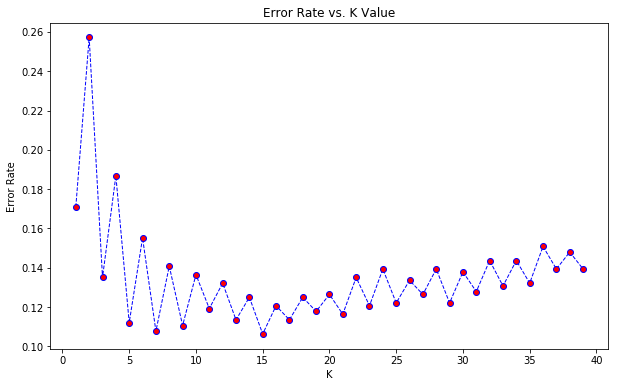

In [12]:
# looking for the K value which has optimal error rate
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    error_rate.append(np.mean(Y_pred != Y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color='blue', lw=1, ls='dashed', marker='o', markerfacecolor='red')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [13]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, Y_train)
pred = knn.predict(X_test)

print("Accuracy: {}%".format(round(accuracy_score(Y_test, pred)*100,2)))

Accuracy: 88.94%
